# CSV to PDF

### No split perfomed
Converting .csv file to pretty .pdf:  

| REGION_NAME | BUSINESS_AREA_NAME | NarrativeTitle                   | NarrativeText |
| ----------- | ------------------ | -------------------------------- | ------------- |
| EAPR        | Cambodia           | Lessons Learned and Innovations  | sdfhjsdf      |
| EAPR        | China              | Lessons Learned and Innovat ions | aslkdgvj      |  

PDF:

Year - 2022, Country - Combodia   
Lessons learned and Innovations for the country Cambodia in the region EAPR for the year 2022 were as follows:  
sdfkljsdf  

Year - 2022, Country - China  
Lessons learned and Innovations for the country China in the region EAPR for the year 2022 were as follows:  
aslkdgvj


In [ ]:
import csv 
# from fpdf import FPDF
# !pip install fasttext-langdetect
# from ftlangdetect import detect
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
in_file_path = '../Lessons learnt Narrative insights/RAM docs/'
out_file_path = '../Lessons learnt Narrative insights/transformed docs/no split/'
file_name = 'RAM3 End-Year Summary Narrative Analysis '
file_years = ['2018','2019','2020','2021','2022']
token_count_dict = {'1 split':0, '2 splits':0 ,'2+ splits':0} 
one_split_narrs, two_split_narrs = [], []

for file_year in file_years:
    with open(in_file_path+file_name+file_year+'.csv','r') as file_in:
        
        reader = csv.reader(file_in, delimiter=',')
        next(reader,None) # skip header here.
        
        with open(out_file_path+file_name+file_year+'.txt','w') as file_out:
            count  = 0
            country_name = None
            for row in reader:
                if row :
                    if row[0] == 'HQ': break
                
                    else:
                        country_name = row[1] 
                        h1 = f'\n\nYear - {file_year}, Country - {country_name}.\n'
                        h2 = f'Lessons learned and Innovations for the country {country_name} in the region EAPR for the year {file_year} were as follows:\n'
                        text = row[3]
                        # '''uncomment the following before running'''
                        # text = text.replace('\n',' ')
                        # is_en = detect(text = text, low_memory = True)
                        # if is_en['lang'] =='en' and is_en['score']>=0.85:

                        #     file_out.write(h1)
                        #     file_out.write(h2)
                        #     file_out.write(row[3])
# '''Expermintal code to save as pdf. '''
            #             pdf.add_page()
            #             pdf.cell(200, 10, txt = h1, ln = 1, align = 'L')
            #             pdf.cell(200, 10, txt = h2, ln = 1, align = 'L')
            #             pdf.cell(200, 10, txt = text, ln = 1, align = 'L')
            # pdf.output(file_path+file_name+file_year+".pdf")   
                        '''check count of tokens in each narrative and plot'''
                        token_count = len(text.split()) * 1.3 # avg. tokens per word.
                        if token_count // 1024 == 0: 
                            token_count_dict['1 split'] += 1 
                            one_split_narrs.append([file_year,country_name])
                        elif token_count // 1024 == 1: 
                            token_count_dict['2 splits'] += 1 
                            two_split_narrs.append([file_year,country_name])
                        else: token_count_dict['2+ splits'] += 1 
                        # y_axis.append(token_count)
                        # x_axis.append(i)            

[Text(0, 0, '98'), Text(0, 0, '433'), Text(0, 0, '56')]

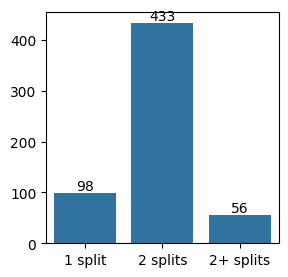

In [53]:
fig,ax = plt.subplots(figsize = (3,3))
sns.barplot(data = token_count_dict)
ax.bar_label(ax.containers[0], fontsize=10)

### Observations:  
* The Azure OpenAI API will divide the docs in chunks of 1024 (max if not specified).
* Most of the docs will get split into 2 chunks. 
* Total narrs = 587. En narrs = 554.  
* Most docs are having more than 2/2+ splits. 
    * That means context that I added in the begining will not be carry forwarded.  
    * In fact, one split might contain more than one year,country data, messing up the context.

### TODO:  
* (DONE) Remove non-eng narratives.
* (CANCELLED) PDF convertion fails at \u2018 character.


# Vector Db

In [5]:
# !pip install chromadb
# !pip install langchain
# !pip install sentence_transformers
# !pip install fasttext-langdetect
# from ftlangdetect import detect #fasttext does not work on local for some reason
import csv
import tqdm
import shutil,os
from termcolor import colored
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain.text_splitter import SentenceTransformersTokenTextSplitter,CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceBgeEmbeddings
from transformers import AutoTokenizer
from chromadb import EmbeddingFunction, Embeddings

d:\anaconda3\envs\unicef_coar\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
in_file_path = '../Lessons learnt Narrative insights/RAM docs/'
out_file_path = '../Lessons learnt Narrative insights/transformed docs/with split/'
file_name = 'RAM3 End-Year Summary Narrative Analysis '
file_years = ['2018','2019','2020','2021','2022']
MAX_SEQ_LEN = 512

embedding_function = HuggingFaceBgeEmbeddings(
    model_name="BAAI/bge-base-en-v1.5",
    # model_kwargs={'device': 'cuda'},
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True},
    query_instruction="Represent this sentence for searching relevant passages: "
)

# text_splitter = RecursiveCharacterTextSplitter(
# chunk_size = 500,
# chunk_overlap  = 20,
# length_function = len,
# add_start_index = True,
# )

tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-base-en-v1.5')

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size=MAX_SEQ_LEN, chunk_overlap=0
)


In [4]:
for file_year in tqdm.tqdm(file_years, desc='year loop'):
    with open(in_file_path+file_name+file_year+'.csv','r') as file_in:

        reader = csv.reader(file_in, delimiter=',')
        next(reader,None) # skip header here.

        country_name = None
        for row in reader:
            if not row : break
            if row[0] == 'HQ': break

            region_name = row[0]
            country_name = row[1]
            # h1 = f'\n\nYear - {file_year}, Country - {country_name}.\n'
            # h2 = f'Lessons learned and Innovations for the country {country_name} in the region EAPR for the year {file_year} were as follows:\n'
            text = row[3]

            """uncomment the following before running"""
            text = text.replace('\n',' ')
            is_en = detect(text = text, low_memory = True)
            if is_en['lang'] =='en' and is_en['score']>=0.85:
              metadata = {
                  'year' : file_year,
                  'region_name' : region_name,
                  'country_name' : country_name
              }
              splits = text_splitter.create_documents([text], metadatas=[metadata])
              db = Chroma.from_documents(splits, embedding_function, persist_directory="./chroma_db")


csv.reader loop: 128it [04:19,  2.03s/it] ?it/s]
csv.reader loop: 128it [02:54,  1.36s/it]:18, 259.60s/it]
csv.reader loop: 135it [03:13,  1.43s/it]:28, 209.65s/it]
csv.reader loop: 135it [03:25,  1.53s/it]:44, 202.21s/it]
csv.reader loop: 61it [01:20,  1.31s/it]3:23, 203.68s/it]
year loop: 100%|██████████| 5/5 [15:13<00:00, 182.72s/it]


In [10]:
question_bank = [
    "What was UNICEF's role in building scalable business models for innovations in humanitarian setting?",
    "How did UNICEF build scalable business models for innovations?",
    "How did UNICEF build a scalable model for innovations for immunization programmes?",
    "developing or designing innovation initiatives and programs"
]

question_prefix = ["How did UNICEF build a scalable model for innovations in ",
                   "What are challenges in building a scalable model for innovations in ",
                   "How did UNICEF work with governments for innovations in ",
                   "What partnerships did UNICEF form for innovations in ",
                   "How did UNICEF fund innovations in ",]

question_suffix = ["humanitarian settings",
                    "education programmes",
                    "technology for development programmes  or for T4D programmes",
                    "child protection programmes",
                    "health programmes",
                    "immunization programmes",
                    "mental health programmes",
                    "nutrition programmes",
                    "youth programmes",
                    "gender equality programmes",
                    "climate change, environment, DRR (disaster risk reduction), energy programmes",
                    "For WASH (water, sanitation, and hygiene)  programmes",
                    ]


In [12]:
db = Chroma(persist_directory="./chroma_db", embedding_function=embedding_function)
retriever = db.as_retriever(persist_directory="./chroma_db", search_type="mmr")
docs = retriever.get_relevant_documents(question_bank[3])
for doc in docs:
    print(colored(f'{doc.metadata}', 'green'), doc.page_content)

{'country_name': 'Egypt', 'region_name': 'MENAR', 'year': '2019'} initiative, called Dawwie. The initiative has a distinctive innovative feature as, rather than attempting to address the specific practices harmful to children, it aims at tackling gender inequality as a root cause of such practices, thus contributing to establish the foundations of a long-term gender norms transformation. The programme recognises that individual behaviors have complex and interconnected determinants and aims at creating a conducive ecosystem to tackle harmful social norms by building a community of institutions and people in supporting girls to fulfill their full potential. Based on the Organized Diffusion of Innovation theory, Dawwie employs social
{'country_name': 'Botswana', 'region_name': 'ESAR', 'year': '2020'} as well as expansion on the use of technology and innovation in the delivery of interventions. A key lesson learned in 2020 is that mainstreaming digitization, innovation and technology in p

In [13]:
retriever = db.as_retriever(search_kwargs={"k": 5})
docs = retriever.get_relevant_documents("What was UNICEF's role in building scalable business model for innovations in humanitarian setting?")

for doc in docs:
    print(colored(f'{doc.metadata}', 'green'), doc.page_content)

{'country_name': 'South Sudan', 'region_name': 'ESAR', 'year': '2018'} will work harder to maintain media coverage of the humanitarian response in light of declining interest.  Creativity, innovation, programme integration and business process improvement will be fostered to increase effectiveness and efficiency in logistics and operational support, building on existing practices while learning from other countries in the region. UNICEF actively participates in the development and refinement of the United Nations business operations strategy, which will serve as a guiding framework to increase and enhance common services, streamline operational practices and reduce duplication. Efforts will be made to strengthen the culture of results to facilitate planning, monitoring, evaluation and
{'country_name': 'Brazil', 'region_name': 'LACR', 'year': '2020'} ensure a timely and effective implementation of in-kind and financial contributions. This was a key element of success for mobilizing USD 

In [14]:
retriever = db.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": .5})
docs = retriever.get_relevant_documents(question_bank[0])
for doc in docs:
    print(colored(f'{doc.metadata}', 'green'), doc.page_content)

{'country_name': 'South Sudan', 'region_name': 'ESAR', 'year': '2018'} will work harder to maintain media coverage of the humanitarian response in light of declining interest.  Creativity, innovation, programme integration and business process improvement will be fostered to increase effectiveness and efficiency in logistics and operational support, building on existing practices while learning from other countries in the region. UNICEF actively participates in the development and refinement of the United Nations business operations strategy, which will serve as a guiding framework to increase and enhance common services, streamline operational practices and reduce duplication. Efforts will be made to strengthen the culture of results to facilitate planning, monitoring, evaluation and
{'country_name': 'Brazil', 'region_name': 'LACR', 'year': '2020'} ensure a timely and effective implementation of in-kind and financial contributions. This was a key element of success for mobilizing USD 

### Observations:  
* creating vector db took ~18 mins on CPU.
* Vector db size = ~60-90 MB.
* Brundi, Jamaica is again at the top like we got in AI playground.

### TODO:  
* (DONE) add metadata to splits. 
* (DONE) improve document splitting.
    * check emb model seq length before using token splitting. 
* (DONE) count docs retrived per year, per country, per region.
* (DONE) try better embedding models.
    * check LB retrieval task: https://huggingface.co/spaces/mteb/leaderboard
    * run the model on google colab GPU : `SentenceTransformer(MODEL_PATH, device="cuda:0")`  


### BUG:  
* Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors.  
    * the `length_function` tells how length is calculated. https://python.langchain.com/docs/modules/data_connection/document_transformers#text-splitters  
    * Or huggingface tokenizer is returning a diff length function than the embedding LM. 

# EDA

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import collections

1 Nicaragua
2 Egypt
3 Botswana
4 Burundi
5 Malawi
6 Pakistan
7 Ethiopia
8 Vietnam
9 Uganda
10 Kosovo (UN SC resolution 1244)
11 Paraguay
12 Timor-Leste
13 Zimbabwe
14 Malaysia
15 Argentina
16 Algeria
17 Sao Tome & Principe
18 China
19 Guyana
20 Indonesia
21 Bhutan
22 Afghanistan
23 Rep of Uzbekistan
24 India
25 Niger
26 Panama
27 Republic of Mozambique
28 United Rep. of Tanzania
29 Kenya
30 Sierra Leone
31 Mali
32 Eswatini
33 Barbados
34 Papua New Guinea
35 Guinea Bissau
[('Malawi', 7), ('Timor-Leste', 3), ('Indonesia', 3), ('Egypt', 2), ('Burundi', 2), ('Pakistan', 2), ('Ethiopia', 2), ('Kosovo (UN SC resolution 1244)', 2), ('Nicaragua', 1), ('Botswana', 1), ('Vietnam', 1), ('Uganda', 1), ('Paraguay', 1), ('Zimbabwe', 1), ('Malaysia', 1), ('Argentina', 1), ('Algeria', 1), ('Sao Tome & Principe', 1), ('China', 1), ('Guyana', 1), ('Bhutan', 1), ('Afghanistan', 1), ('Rep of Uzbekistan', 1), ('India', 1), ('Niger', 1), ('Panama', 1), ('Republic of Mozambique', 1), ('United Rep. of Tanzani

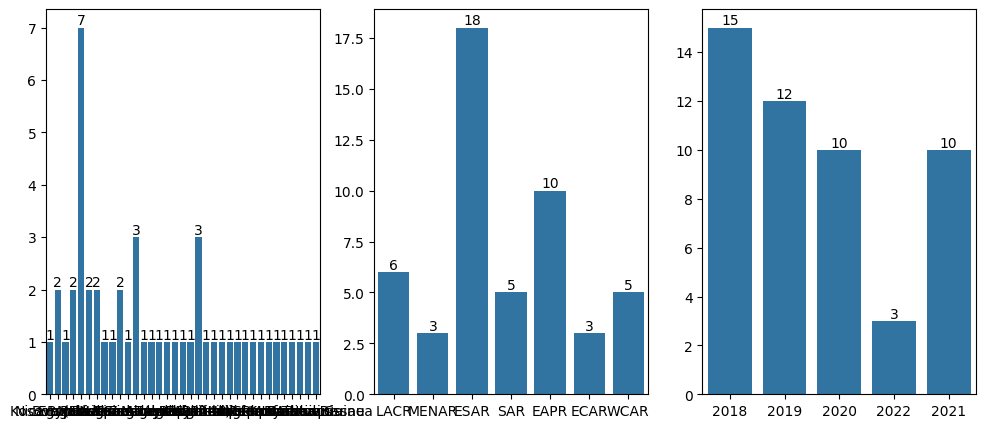

In [16]:
retriever = db.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": .4,  "k": 50})
docs = retriever.get_relevant_documents(question_bank[3])

country_counter = collections.Counter()
region_counter = collections.Counter()
year_counter = collections.Counter()

# for doc in docs:
#   print(doc.metadata)

for doc in docs:
  # these are counting no. of splits that matched. its not the abs. count.
    country_counter[doc.metadata['country_name']] += 1
    region_counter[doc.metadata['region_name']] += 1
    year_counter[doc.metadata['year']] += 1

for count, k in enumerate(country_counter.keys()):
  print(count+1, k)

print(country_counter.most_common())

ax = []
fig, ax_subplot = plt.subplots(1,3, figsize=(12,5))
for ax,counter in zip(ax_subplot,[country_counter,region_counter,year_counter]):
  sns.barplot(x = [k for k in counter.keys()],
            y = [v for v in counter.values()],
            ax=ax)
  ax.bar_label(ax.containers[0])

plt.show()

In [17]:
db = Chroma(persist_directory="./chroma_db", embedding_function=embedding_function)
print(f"total embeddings saved: {db._collection.count()}")
sample_emb = db.get(#ids=['92905112-7f14-11ee-8e84-0242ac1c000c','929052ca-7f14-11ee-8e84-0242ac1c000c'],
             where={"country_name": "Venezuela"},
             where_document={"$contains":"innovation"},
             include = ["embeddings","metadatas", "documents"])['embeddings']
print(len(sample_emb))

total embeddings saved: 6186
3


In [19]:
# !pip install umap-learn
import umap.umap_ as umap
import matplotlib.pyplot as plt

sample_emb = db.get(include = ["embeddings"])['embeddings']

umap_obj = umap.UMAP(n_components=2,
                  metric='l2', #try diff metric.
                  n_neighbors=3 # very sensitive but good clustering until 5
                     )

umap_embedding = umap_obj.fit(sample_emb)
print(len(sample_emb),len(sample_emb[0]))
# print(umap_embedding.shape)
print(umap_embedding.embedding_.shape)

     ---------------------------------------- 0.0/90.8 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/90.8 kB ? eta -:--:--
     ------------ ------------------------- 30.7/90.8 kB 262.6 kB/s eta 0:00:01
     -------------------------------------- 90.8/90.8 kB 571.5 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ------------------ --------------------- 0.5/1.1 MB 16.5 MB/s eta 0:00:01
     ---------------------------------------  1.1/1.1 MB 14.4 MB/s eta 0:00:01
     ---------------------------------------- 1.1/1.1 MB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------- ----------------------------- 0.7/2.6 MB 22.5 MB/s eta 0:00:01
   ------------------ ---------------

ERROR: Invalid requirement: 'datashader,'
  You can safely remove it manually.


     ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
     ------ --------------------------------- 0.3/1.7 MB 5.2 MB/s eta 0:00:01
     ----------------- ---------------------- 0.7/1.7 MB 6.5 MB/s eta 0:00:01
     --------------------------- ------------ 1.1/1.7 MB 8.1 MB/s eta 0:00:01
     ------------------------------------- -- 1.6/1.7 MB 7.7 MB/s eta 0:00:01
     ---------------------------------------- 1.7/1.7 MB 7.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/55.8 kB ? eta -:--:--
     ---------------------------------------- 55.8/55.8 kB 2.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.8 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/6.8 MB 25.1 MB/s eta 0:00:01
   --------- ------------------------------ 1.7/6.8 MB 21.5 MB/s eta 0:00:01
   --------------- ------------------------ 2.7/6.8 MB 21.5 MB/s eta 0:00:01
   --------------------- ------------------ 3.7/6.8 MB 21.3 MB/s eta 0:00:01
   -------

d:\anaconda3\envs\unicef_coar\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)
d:\anaconda3\envs\unicef_coar\lib\site-packages\umap\plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

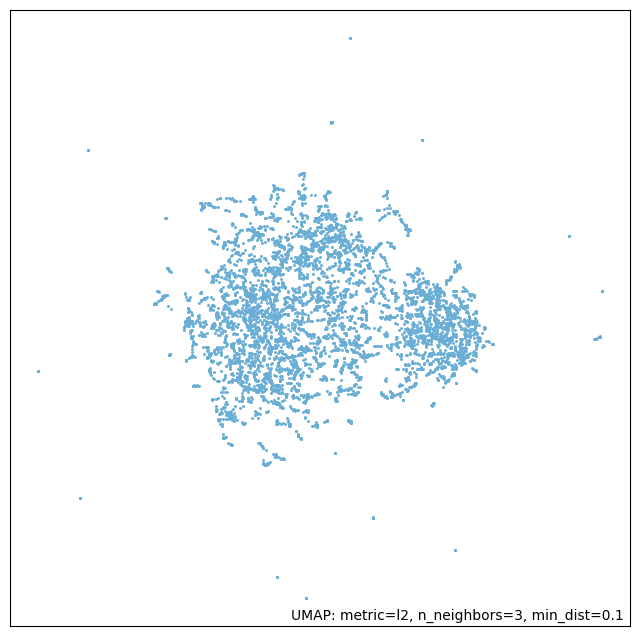

In [20]:
# !pip install bokeh, holoviews, scikit-image,  colorcet
# !pip install umap-learn[plot]
import umap.plot
import matplotlib.pyplot as plt
umap.plot.points(umap_embedding)
# plt.scatter(umap_embedding[:,0], umap_embedding[:,1], c=sample_emb, cmap='Spectral')
# plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');
# plt.show()


#TODO: try interactive plot with tooltip, that has doc text